Difference CAR

In [24]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, ttest_1samp
import matplotlib.pyplot as plt
import warnings
from scipy.interpolate import PchipInterpolator
warnings.filterwarnings("ignore")

In [25]:
data_path = '../data/monthly/monthly.csv'
monthly_raw_data = pd.read_csv(data_path)

# 将 RETX、ewretd 转为数值型
monthly_raw_data['RETX'] = pd.to_numeric(monthly_raw_data['RETX'], errors='coerce')
monthly_raw_data['ewretd'] = pd.to_numeric(monthly_raw_data['ewretd'], errors='coerce')

# 用 (RETX - ewretd) 得到“超额收益”
monthly_raw_data['RETX'] = monthly_raw_data['RETX'] - monthly_raw_data['ewretd']

# 去除 NaN 以及RETX为C或者B的行
cleaned_data = monthly_raw_data.dropna(subset=['RETX'])
shape_before = monthly_raw_data.shape
cleaned_data = cleaned_data[~cleaned_data['RETX'].isin(['B','C'])]
shape_after = cleaned_data.shape
print(f"RETX为B或C的行有 {shape_before[0] - shape_after[0]} 行，已经被删除。")

# 转换日期
cleaned_data['date'] = pd.to_datetime(cleaned_data['date'])

# 保证每支股票 >= 85 个月的数据
stocks_with_enough_data = cleaned_data.groupby('PERMNO').filter(lambda x: len(x) >= 85)

# 按 (PERMNO, date) 排序
stocks_with_enough_data = stocks_with_enough_data.sort_values(['PERMNO','date']).reset_index(drop=True)
print(f"符合条件的股票数量: {stocks_with_enough_data['PERMNO'].nunique()}")

market_data = cleaned_data.groupby('date')['ewretd'].mean().reset_index()
#计算累计收益,累加计算不用累乘
market_data['cumulative_ewretd'] = market_data['ewretd'].cumsum()

RETX为B或C的行有 58583 行，已经被删除。
符合条件的股票数量: 5191


In [26]:
def calculate_cumulative_excess_returns(group):
    """
    对每只股票按日期顺序,按原文应为加和而非乘积
    """
    # group 已按日期排序
    group['cum_excess_return'] = group['RETX'].rolling(window=12, min_periods=12).sum()
    return group

stocks_with_enough_data = (
    stocks_with_enough_data
    .groupby('PERMNO', group_keys=False)
    .apply(calculate_cumulative_excess_returns)
)

In [27]:
start_date = pd.Timestamp('1933-01-01')
end_date = pd.Timestamp('1983-01-01')

# 定义起始和结束日期
start_date = pd.Timestamp('1931-01-01')
end_date = pd.Timestamp('1983-01-01')

# 生成49个1年的周期
one_year_periods = pd.date_range(start=start_date, end=end_date, freq='AS')[:49]
print("One-Year Periods:")
print(one_year_periods)

# 生成24个2年的周期
two_year_periods = [start_date + pd.DateOffset(years=2 * i) for i in range(24)]
print("\nTwo-Year Periods:")
print(two_year_periods)

# 生成16个3年的周期
three_year_periods = [start_date + pd.DateOffset(years=3 * i) for i in range(16)]
print("\nThree-Year Periods:")
print(three_year_periods)



One-Year Periods:
DatetimeIndex(['1931-01-01', '1932-01-01', '1933-01-01', '1934-01-01',
               '1935-01-01', '1936-01-01', '1937-01-01', '1938-01-01',
               '1939-01-01', '1940-01-01', '1941-01-01', '1942-01-01',
               '1943-01-01', '1944-01-01', '1945-01-01', '1946-01-01',
               '1947-01-01', '1948-01-01', '1949-01-01', '1950-01-01',
               '1951-01-01', '1952-01-01', '1953-01-01', '1954-01-01',
               '1955-01-01', '1956-01-01', '1957-01-01', '1958-01-01',
               '1959-01-01', '1960-01-01', '1961-01-01', '1962-01-01',
               '1963-01-01', '1964-01-01', '1965-01-01', '1966-01-01',
               '1967-01-01', '1968-01-01', '1969-01-01', '1970-01-01',
               '1971-01-01', '1972-01-01', '1973-01-01', '1974-01-01',
               '1975-01-01', '1976-01-01', '1977-01-01', '1978-01-01',
               '1979-01-01'],
              dtype='datetime64[ns]', freq='AS-JAN')

Two-Year Periods:
[Timestamp('1931-01-01 00:00

In [28]:
all_periods = []
for start_dt in one_year_periods:
    # 4.1 组合形成日 = 起点前1个月末
    formation_date = start_dt - pd.offsets.MonthEnd(1)
    
    # lookback: 过去12个月区间 [formation_date-11M, formation_date]
    lookback_end = formation_date
    lookback_start = formation_date - pd.DateOffset(months=12)
    print(f"\n组合形成日: {formation_date.date()}，lookback区间: {lookback_start.date()} - {lookback_end.date()}")
    
    # lookback: 过去12个月区间 [formation_date-12M, formation_date]
    lookback_end = formation_date
    lookback_start = formation_date - pd.DateOffset(months=11)

    # 提取 lookback 区间的数据
    lookback_df = stocks_with_enough_data[
        (stocks_with_enough_data['date'] >= lookback_start) &
        (stocks_with_enough_data['date'] <= lookback_end)
    ].copy()
    if lookback_df.empty:
        # 没数据就跳过
        continue

    # 对每只股票取 <= formation_date 最新一条记录
    sub = lookback_df[lookback_df['date'] <= formation_date]
    # 每只股票只保留最后一条(含 cum_excess_return)
    portfolio_data = sub.groupby('PERMNO', group_keys=False).tail(1).copy()
    
    # 排序，选最高35(赢家), 最低35(输家)
    portfolio_data = portfolio_data.sort_values('cum_excess_return', ascending=False)
    # 先删除cum_excess_return缺失的行
    portfolio_data = portfolio_data.dropna(subset=['cum_excess_return'])
    winner_ids = portfolio_data.head(35)['PERMNO']
    loser_ids  = portfolio_data.tail(35)['PERMNO']

    # -------------- 日志功能：打印调仓信息 -------------
    print("\n[调仓日期: {}]".format(formation_date.date()))
    print("  Winner组合股票数:", len(winner_ids))
    print("  Loser组合股票数:", len(loser_ids))
    # 如果还想查看具体股票ID，可直接打印 winner_ids.values 等
    # print("  Winner IDs:", winner_ids.values)
    # print("  Loser IDs:", loser_ids.values)
    # -----------------------------------------------

    # 4.2 三年持有期 = [start_dt, start_dt+24个月 - 1天]
    hold_start = start_dt
    hold_end   = start_dt + pd.DateOffset(months=24) - pd.Timedelta(days=1)
    
    # 赢家/输家组合 在持有期内的数据
    w_hold = stocks_with_enough_data[
        (stocks_with_enough_data['PERMNO'].isin(winner_ids)) &
        (stocks_with_enough_data['date'] >= hold_start) &
        (stocks_with_enough_data['date'] <= hold_end)
    ].copy()
    l_hold = stocks_with_enough_data[
        (stocks_with_enough_data['PERMNO'].isin(loser_ids)) &
        (stocks_with_enough_data['date'] >= hold_start) &
        (stocks_with_enough_data['date'] <= hold_end)
    ].copy()
    
    # 若两组都无数据，也要存个空表做记录
    if w_hold.empty or l_hold.empty:
        all_periods.append(pd.DataFrame({
            'test_period_start': [start_dt],
            'date': [None],
            'avg_u_w': [np.nan],
            'avg_u_l': [np.nan],
        }))
        continue

    # 4.3 每月组合收益
    # 赢家组合：按月份聚合求均值
    w_monthly = w_hold.groupby('date', as_index=False)['RETX'].mean()
    w_monthly.rename(columns={'RETX':'avg_u_w'}, inplace=True)

    # 输家组合：按月份聚合求均值
    l_monthly = l_hold.groupby('date', as_index=False)['RETX'].mean()
    l_monthly.rename(columns={'RETX':'avg_u_l'}, inplace=True)

    # 生成完整的月末区间
    all_months = pd.date_range(hold_start, hold_end, freq='M')
    hold_months_df = pd.DataFrame({'date':all_months})

    # 合并赢家/输家
    merged = (
        hold_months_df
        .merge(w_monthly, on='date', how='left')
        .merge(l_monthly, on='date', how='left')
    )

    # 计算累计收益 (CAR_w, CAR_l) = 对 avg_u_* 的累加/累积
    
    # 累加
    merged['CAR_w'] = merged['avg_u_w'].cumsum(skipna=True)
    merged['CAR_l'] = merged['avg_u_l'].cumsum(skipna=True)
    
    # 标注测试期起点
    merged['test_period_start'] = start_dt
    
    all_periods.append(merged)

# 合并所有测试期
all_periods_df = pd.concat(all_periods, ignore_index=True)
# 排序
all_periods_df.sort_values(['test_period_start','date'], inplace=True)

def add_relative_month(df_):
    """
    为单个测试期添加相对月编号 t=1..36。
    """
    df_ = df_.sort_values('date').reset_index(drop=True)
    df_['t'] = np.arange(len(df_)) + 1
    return df_

all_periods_df = all_periods_df.groupby('test_period_start', group_keys=False).apply(add_relative_month)

# 对同一个 t 跨测试期求均值 => ACAR_w, ACAR_l
acar = all_periods_df.groupby('t', as_index=False).agg({
    'CAR_w':'mean',
    'CAR_l':'mean'
})
acar.rename(columns={'CAR_w':'ACAR_w','CAR_l':'ACAR_l'}, inplace=True)
acar['diff'] = acar['ACAR_l'] - acar['ACAR_w']

print("====== ACAR (平均累计收益) ======")
print(acar[['t','ACAR_w','ACAR_l','diff']])  # 只展示主要列


组合形成日: 1930-12-31，lookback区间: 1929-12-31 - 1930-12-31

[调仓日期: 1930-12-31]
  Winner组合股票数: 35
  Loser组合股票数: 35

组合形成日: 1931-12-31，lookback区间: 1930-12-31 - 1931-12-31

[调仓日期: 1931-12-31]
  Winner组合股票数: 35
  Loser组合股票数: 35

组合形成日: 1932-12-31，lookback区间: 1931-12-31 - 1932-12-31

[调仓日期: 1932-12-31]
  Winner组合股票数: 35
  Loser组合股票数: 35

组合形成日: 1933-12-31，lookback区间: 1932-12-31 - 1933-12-31

[调仓日期: 1933-12-31]
  Winner组合股票数: 35
  Loser组合股票数: 35

组合形成日: 1934-12-31，lookback区间: 1933-12-31 - 1934-12-31

[调仓日期: 1934-12-31]
  Winner组合股票数: 35
  Loser组合股票数: 35

组合形成日: 1935-12-31，lookback区间: 1934-12-31 - 1935-12-31

[调仓日期: 1935-12-31]
  Winner组合股票数: 35
  Loser组合股票数: 35

组合形成日: 1936-12-31，lookback区间: 1935-12-31 - 1936-12-31

[调仓日期: 1936-12-31]
  Winner组合股票数: 35
  Loser组合股票数: 35

组合形成日: 1937-12-31，lookback区间: 1936-12-31 - 1937-12-31

[调仓日期: 1937-12-31]
  Winner组合股票数: 35
  Loser组合股票数: 35

组合形成日: 1938-12-31，lookback区间: 1937-12-31 - 1938-12-31

[调仓日期: 1938-12-31]
  Winner组合股票数: 35
  Loser组合股票数: 35

组合形成日: 19

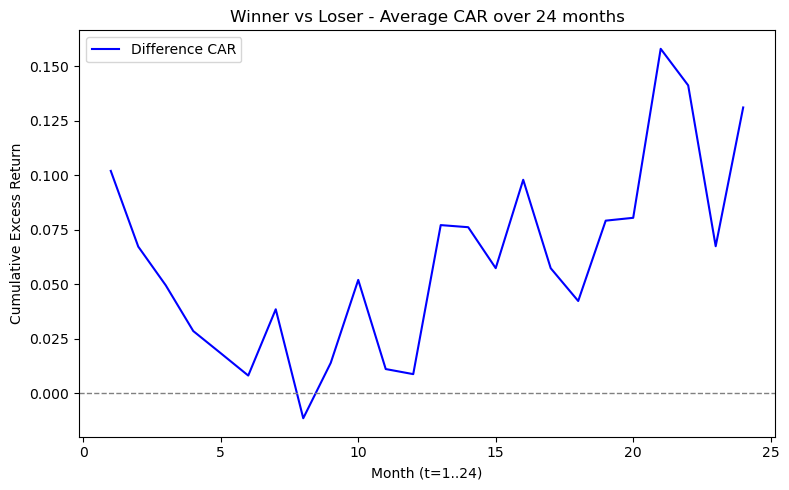

In [29]:
plt.figure(figsize=(8,5))
plt.plot(acar['t'], acar['diff'], label='Difference CAR', color='blue')
#plt.plot(acar['t'], acar['ACAR_l'], label='Loser (ACAR)', color='red')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
plt.xlabel('Month (t=1..24)')
plt.ylabel('Cumulative Excess Return')
plt.title('Winner vs Loser - Average CAR over 24 months')
plt.legend()
plt.tight_layout()
plt.show()

In [30]:
def calculate_cumulative_excess_returns(group, window):
    """
    对每只股票按日期顺序，计算累计超额收益。
    窗口大小根据 formation period 动态调整。
    """
    # group 已按日期排序
    group['cum_excess_return'] = group['RETX'].rolling(window=window, min_periods=window).sum()
    return group

# 动态计算 cumulative_excess_return 的函数
def calculate_acar_for_periods_dynamic(periods, months, stocks_with_enough_data, window):
    all_periods = []
    
    # 重新计算每个股票的累计收益
    stocks_with_window = (
        stocks_with_enough_data
        .groupby('PERMNO', group_keys=False)
        .apply(calculate_cumulative_excess_returns, window=window)
    )
    
    # 依次处理每个 formation period
    for start_dt in periods:
        # 形成期日期
        formation_date = start_dt - pd.offsets.MonthEnd(1)
        lookback_end = formation_date
        lookback_start = formation_date - pd.DateOffset(months=window)
        
        # 提取 lookback 区间数据
        lookback_df = stocks_with_window[
            (stocks_with_window['date'] >= lookback_start) &
            (stocks_with_window['date'] <= lookback_end)
        ].copy()
        if lookback_df.empty:
            continue

        sub = lookback_df[lookback_df['date'] <= formation_date]
        portfolio_data = sub.groupby('PERMNO', group_keys=False).tail(1).copy()
        portfolio_data = portfolio_data.sort_values('cum_excess_return', ascending=False)
        portfolio_data = portfolio_data.dropna(subset=['cum_excess_return'])
        winner_ids = portfolio_data.head(35)['PERMNO']
        loser_ids = portfolio_data.tail(35)['PERMNO']
        
        hold_start = start_dt
        hold_end = start_dt + pd.DateOffset(months=months) - pd.Timedelta(days=1)
        
        # 持有期内赢家/输家组合
        w_hold = stocks_with_window[
            (stocks_with_window['PERMNO'].isin(winner_ids)) &
            (stocks_with_window['date'] >= hold_start) &
            (stocks_with_window['date'] <= hold_end)
        ].copy()
        l_hold = stocks_with_window[
            (stocks_with_window['PERMNO'].isin(loser_ids)) &
            (stocks_with_window['date'] >= hold_start) &
            (stocks_with_window['date'] <= hold_end)
        ].copy()
        
        if w_hold.empty or l_hold.empty:
            all_periods.append(pd.DataFrame({
                'test_period_start': [start_dt],
                'date': [None],
                'avg_u_w': [np.nan],
                'avg_u_l': [np.nan],
            }))
            continue
        
        # 每月平均收益
        w_monthly = w_hold.groupby('date', as_index=False)['RETX'].mean()
        w_monthly.rename(columns={'RETX':'avg_u_w'}, inplace=True)
        l_monthly = l_hold.groupby('date', as_index=False)['RETX'].mean()
        l_monthly.rename(columns={'RETX':'avg_u_l'}, inplace=True)
        
        # 月末区间
        all_months = pd.date_range(hold_start, hold_end, freq='M')
        hold_months_df = pd.DataFrame({'date': all_months})
        merged = (
            hold_months_df
            .merge(w_monthly, on='date', how='left')
            .merge(l_monthly, on='date', how='left')
        )
        
        # 累计收益
        merged['CAR_w'] = merged['avg_u_w'].cumsum(skipna=True)
        merged['CAR_l'] = merged['avg_u_l'].cumsum(skipna=True)
        merged['test_period_start'] = start_dt
        all_periods.append(merged)

    # 合并
    all_periods_df = pd.concat(all_periods, ignore_index=True)
    all_periods_df.sort_values(['test_period_start', 'date'], inplace=True)
    
    # 相对月编号
    def add_relative_month(df_):
        df_ = df_.sort_values('date').reset_index(drop=True)
        df_['t'] = np.arange(len(df_)) + 1
        return df_

    all_periods_df = all_periods_df.groupby('test_period_start', group_keys=False).apply(add_relative_month)
    
    # 计算ACAR
    acar = all_periods_df.groupby('t', as_index=False).agg({
        'CAR_w':'mean',
        'CAR_l':'mean'
    })
    acar.rename(columns={'CAR_w':'ACAR_w', 'CAR_l':'ACAR_l'}, inplace=True)
    acar['diff'] = acar['ACAR_l'] - acar['ACAR_w']
    return acar

# 计算49个1年、24个2年、16个3年的结果
acar_one_year = calculate_acar_for_periods_dynamic(one_year_periods, 24, stocks_with_enough_data, window=12)
acar_two_year = calculate_acar_for_periods_dynamic(two_year_periods, 24, stocks_with_enough_data, window=24)
acar_three_year = calculate_acar_for_periods_dynamic(three_year_periods, 24, stocks_with_enough_data, window=36)


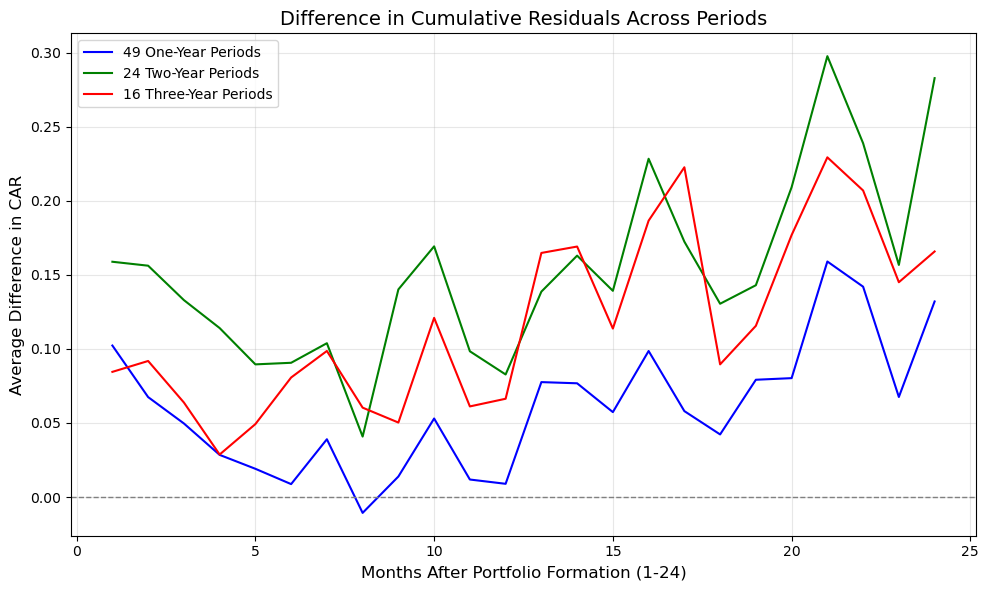

In [31]:
# 绘图
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator

# 平滑曲线
time = acar_one_year['t']
smooth_one = PchipInterpolator(time, acar_one_year['diff'])(time)
smooth_two = PchipInterpolator(time, acar_two_year['diff'])(time)
smooth_three = PchipInterpolator(time, acar_three_year['diff'])(time)

# 绘图
plt.figure(figsize=(10, 6))
plt.plot(time, smooth_one, label='49 One-Year Periods', color='blue')
plt.plot(time, smooth_two, label='24 Two-Year Periods', color='green')
plt.plot(time, smooth_three, label='16 Three-Year Periods', color='red')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)  # 基准线

# 图表信息
plt.title('Difference in Cumulative Residuals Across Periods', fontsize=14)
plt.xlabel('Months After Portfolio Formation (1-24)', fontsize=12)
plt.ylabel('Average Difference in CAR', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()